# Telco Customer Churn

In [1]:
# set task name
task_name = 'telco_churn'

# load common
%run common.ipynb

## ML Discovery

In [2]:
from ds_discovery import Wrangle, FeatureCatalog, ModelsBuilder, Commons

In [3]:
ml = ModelsBuilder.from_memory()
wr = Wrangle.from_memory()

In [4]:
uri = Wrangle.from_env("telco_churn").get_persist_contract().uri
ml.set_source_uri(uri=uri)
ml.pm_persist()

In [5]:
df = ml.load_source_canonical()
df.shape

(7043, 31)

In [7]:
fc = FeatureCatalog.from_memory()

In [8]:
df_coeff = fc.tools.select_classifier_coefficient(df, target='Churn', seed=12)

In [9]:
df_ml = df_coeff
df_ml.shape

(7043, 6)

### Model Preprocess

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# Transform
df_ml['TotalCharges'] = wr.tools.correlate_numbers(df_ml, header='TotalCharges', transform='boxcox')

In [12]:
# Normalize
df_ml['TotalCharges'] = wr.tools.correlate_numbers(df_ml, header='TotalCharges', normalize=(-1,1))
df_ml['MonthlyCharges'] = wr.tools.correlate_numbers(df_ml, header='MonthlyCharges', normalize=(-1,1))

In [13]:
# accommodate the bias
df_ml['ones'] = wr.tools.get_noise(df_ml.shape[0], ones=True)

In [14]:
# select X, Y and convert to numpy matrix
X = df_ml.drop('Churn', axis=1).to_numpy()
y = df_ml['Churn'].to_numpy().astype(np.int32)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4718, 6), (2325, 6), (4718,), (2325,))

### Logistic Regression old school
$$ y = \sigma( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}} $$

In [17]:
# for the moment give it rand norm weight and bias zero
D = X_train.shape[1]
w = np.random.randn(D)
b = 0

In [18]:
# predictions
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

# forward gate
def forward(X, w, b):
    return sigmoid(X.dot(w) + b)

In [19]:
# P(Y | X) - Probabiliy of Y given X
P_Y_given_X = forward(X_train, w, b)

# make it 1's and 0's
predictions = np.round(P_Y_given_X)

In [1]:
# untrained classification rate
np.mean(y_train==predictions)

NameError: name 'np' is not defined

### Logistic Regression with sklearn

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [22]:
ml.pm.task_name

'temporary_in_memory_instance'

In [23]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

ml.set_trained_model(log_reg)

canonical = df_ml.drop('Churn', axis=1)

model = ml.load_canonical(connector_name=ml.pm.CONNECTOR_PREDICT)
predict = model.predict(canonical)
df_pred = pd.DataFrame(predict, columns=['predict'])
result = pd.concat([df_pred, canonical], axis=1)
result.columns


LogisticRegression(solver='liblinear')

Index(['predict', 'TotalCharges', 'Tenure', 'MonthlyCharges',
       'InternetService_Fiber optic', 'PaymentMethod_Electronic check',
       'ones'],
      dtype='object')

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1698
           1       0.66      0.46      0.54       627

    accuracy                           0.79      2325
   macro avg       0.74      0.69      0.70      2325
weighted avg       0.78      0.79      0.78      2325



### ROC AUC

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'ROC Curve')

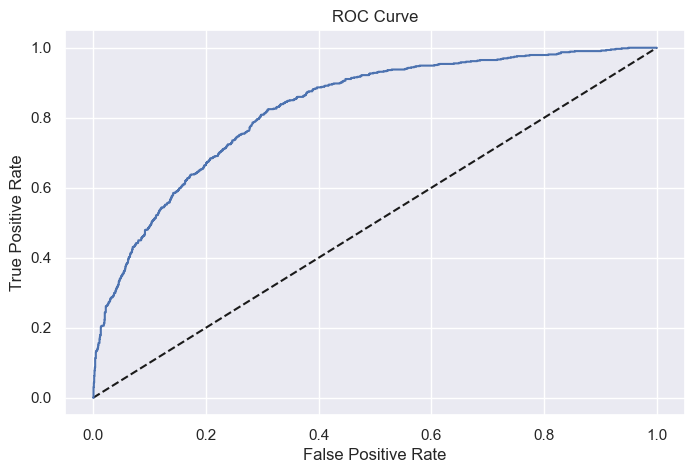

In [25]:
# ROC
y_pred_prob = log_reg.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()